<a href="https://colab.research.google.com/github/emanuelfakh/Face-Recognition/blob/master/FR_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installing packages

- keras - deep learning
- scikit-learn - general purpose machine learning
- imbalanced-learn - methods that address class imbalance problem

In [1]:
!pip install keras scikit-learn imbalanced-learn


### Imports that we'll use along the way

- numpy - linear algebra
- keras - deep learning
- sklearn.dataset - to download Labeled Faces in the Wild dataset
- sklearn.model_selection - for dataset train/test split
- sklearn.metrics - to measure the performance of our classifier
- matplotlib.pyplot - showing images and plots
- imblearn.over_sampling - random oversampling method to handle class imalance

In [2]:
import numpy as np
import keras
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
%matplotlib inline
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


### Labeled Faces in the Wild dataset

The cell below downloads the dataset using `fetch_lfw_people` function and checks the dimensionality of the datset.

There are some parameters that control e.g. the minimum number of images per class (person), image size, etc.

Here is a link to the function's documentation: [fetch_lfw_people](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html).

In [3]:
lfw_people = fetch_lfw_people(min_faces_per_person=20, color=True, resize=1.0,
                              slice_=(slice(48, 202), slice(48, 202)))

X = lfw_people.images
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print('number of examples: {}'.format(y.shape[0]))
print('dimensionality of images: {}'.format(X.shape[1:]))
print('number of unique classes (people): {}'.format(n_classes))

number of examples: 3023
dimensionality of images: (154, 154, 3)
number of unique classes (people): 62


**Printing names of 62 classes / Celebrities**


In [7]:
print (target_names)


['Alejandro Toledo' 'Alvaro Uribe' 'Amelie Mauresmo' 'Andre Agassi'
 'Angelina Jolie' 'Ariel Sharon' 'Arnold Schwarzenegger'
 'Atal Bihari Vajpayee' 'Bill Clinton' 'Carlos Menem' 'Colin Powell'
 'David Beckham' 'Donald Rumsfeld' 'George Robertson' 'George W Bush'
 'Gerhard Schroeder' 'Gloria Macapagal Arroyo' 'Gray Davis'
 'Guillermo Coria' 'Hamid Karzai' 'Hans Blix' 'Hugo Chavez' 'Igor Ivanov'
 'Jack Straw' 'Jacques Chirac' 'Jean Chretien' 'Jennifer Aniston'
 'Jennifer Capriati' 'Jennifer Lopez' 'Jeremy Greenstock' 'Jiang Zemin'
 'John Ashcroft' 'John Negroponte' 'Jose Maria Aznar'
 'Juan Carlos Ferrero' 'Junichiro Koizumi' 'Kofi Annan' 'Laura Bush'
 'Lindsay Davenport' 'Lleyton Hewitt' 'Luiz Inacio Lula da Silva'
 'Mahmoud Abbas' 'Megawati Sukarnoputri' 'Michael Bloomberg' 'Naomi Watts'
 'Nestor Kirchner' 'Paul Bremer' 'Pete Sampras' 'Recep Tayyip Erdogan'
 'Ricardo Lagos' 'Roh Moo-hyun' 'Rudolph Giuliani' 'Saddam Hussein'
 'Serena Williams' 'Silvio Berlusconi' 'Tiger Woods' 'Tom Das

**Let's plot a histogram showing how many examples per class we have.**

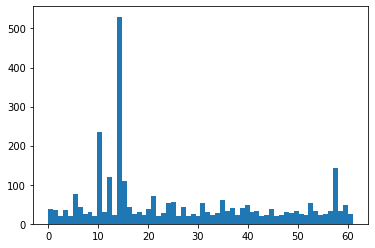

In [8]:
_ = plt.hist(y, bins=n_classes)

**Next, we display a random image along with its label.**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Megawati Sukarnoputri


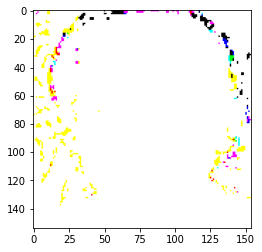

In [9]:
i = np.random.randint(len(lfw_people.images))
plt.imshow(lfw_people.images[i] * 255)
plt.grid(False)
print(target_names[y[i]])

### Deep learning

Let's build an **All Convolutional Net** inspired model [Striving for Simplicity: The All Convolutional Net](https://arxiv.org/abs/1412.6806).

First, we need to import some layer objects from Keras.

In [0]:
from keras.layers import Input
from keras.layers import Conv2D, GlobalAvgPool2D
from keras.layers import Dropout, Activation


Below we define our model.
It consists of 10 convolutional layers with increasing number of filters (from 12 to 48).
Every second layer has kernels of size `(2, 2)` with strides `(2, 2)` and serves the purpose of a trainable pooling layer since it reduces spacial dimensionality.
After that, we add Dropout for regularization which sets 50% of randomly chosen activations to 0.
Then, we add the last convolutional layer for dimensionality expansion to match the number of classes that we predict.
Finallly, we apply global average polling to squash spacial dimenaions.
We could do that with another convolutional layer or a fully connected leyer, however, it would increase the number of weights to train and, in turn, a risk of overfitting.


In [0]:
input = Input(shape=X.shape[1:])                                  # 154x154x3
x = Conv2D(12, (3, 3), padding='same', activation='relu')(input)  # 154x154x12
x = Conv2D(12, (2, 2), strides=(2, 2), activation='relu')(x)      # 77x77x12
x = Conv2D(16, (3, 3), padding='same', activation='relu')(x)      # 77x77x16
x = Conv2D(16, (2, 2), strides=(2, 2), activation='relu')(x)      # 38x38x16
x = Conv2D(24, (3, 3), padding='same', activation='relu')(x)      # 38x38x24
x = Conv2D(24, (2, 2), strides=(2, 2), activation='relu')(x)      # 19x19x24
x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)      # 19x19x32
x = Conv2D(32, (2, 2), strides=(2, 2), activation='relu')(x)      # 9x9x32
x = Conv2D(48, (3, 3), padding='same', activation='relu')(x)      # 9x9x48
x = Conv2D(48, (2, 2), strides=(2, 2), activation='relu')(x)      # 4x4x48
x = Dropout(0.5)(x)                                               # 4x4x48
x = Conv2D(n_classes, (1, 1))(x)                                  # 4x4x62
x = GlobalAvgPool2D()(x)                                          # 62
output = Activation('softmax')(x)                                 # 62


# Plotting the CNN architecture

In [12]:
from keras.models import Model
model = Model(inputs=input, outputs=output)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 154, 154, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 154, 154, 12)      336       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 77, 77, 12)        588       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 77, 77, 16)        1744      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 38, 38, 16)        1040      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 38, 38, 24)        3480      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 19, 19, 24)        2328


**We createa a `DataGenerator` object for adding some data augmentation to prevent overfitting.**

In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.1)

### Training

At this point we are ready to define training procedure that involves setting some hyperparameters, e.g. batch size, optimization algorithm and base learning rate, number of epochs, etc.

In addition, since we know that our dataset is imbalanced, it's good to use oversampling, as it was shown in [A systematic study of the class imbalance problem in convolutional neural networks](https://arxiv.org/abs/1710.05381).

In [0]:
from keras import Model

batch_size = 256
test_split = 0.2
base_lr = 0.001
epochs = 120

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split, 
                                                    stratify=y, random_state=42)

# oversampling each class to contain at least 256 examples
sampling_targets = np.maximum([256] * n_classes, np.bincount(y_train))
ratio_dict = dict(zip(range(n_classes), sampling_targets))
ros = RandomOverSampler(ratio=ratio_dict, random_state=42)

X_train_shape = X_train.shape
X_train = np.reshape(X_train, (X_train_shape[0], -1))
X_train, y_train = ros.fit_sample(X_train, y_train)
X_train = np.reshape(X_train, (len(X_train),) + X_train_shape[1:])

# encoding of labels
y_train = keras.utils.to_categorical(y_train, n_classes)
y_test = keras.utils.to_categorical(y_test, n_classes)

# compile model and define optimization
model = Model(inputs=input, outputs=output)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Nadam(lr=base_lr),
              metrics=['accuracy'])

# model training 🎉
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, y_test))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/120
63/62 [==============================] - 76s 1s/step - loss: 4.1804 - acc: 0.0207 - val_loss: 4.0757 - val_acc: 0.0760
Epoch 2/120
63/62 [==============================] - 75s 1s/step - loss: 4.0783 - acc: 0.0344 - val_loss: 3.8803 - val_acc: 0.0430
Epoch 3/120
63/62 [==============================] - 73s 1s/step - loss: 3.9100 - acc: 0.0508 - val_loss: 3.7042 - val_acc: 0.1421
Epoch 4/120
63/62 [==============================] - 71s 1s/step - loss: 3.7800 - acc: 0.0622 - val_loss: 3.8741 - val_acc: 0.0777
Epoch 5/120
63/62 [==============================] - 71s 1s/step - loss: 3.6380 - acc: 0.0832 - val_loss: 3.5166 - val_acc: 0.1372
Epoch 6/120
63/62 [==============================] - 75s 1s/step - loss: 3.4682 - acc: 0.1185 - val_loss: 3.3197 - val_acc: 0.1587
Epoch 7/120
63/62 [==============================] - 75s 1s/step - loss: 3.3191 - acc: 0.1479 - val_loss: 3.1548 - val_acc: 0.2149
Epoch 8/120
63/62 [==============================] - 75s 1s/step - loss: 3.1351 - a

In [0]:
model.save('weights.h5')

**Saving the trained weight to Google Drive.**

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# PyDrive reference:
# https://googledrive.github.io/PyDrive/docs/build/html/index.html

# 2. Create & upload a file text file.
uploaded = drive.CreateFile({'title': 'weights.h5'})
uploaded.SetContentFile('weights.h5')
uploaded.Upload()

### Results

**Let's plot the training history to assess model's accuracy.**


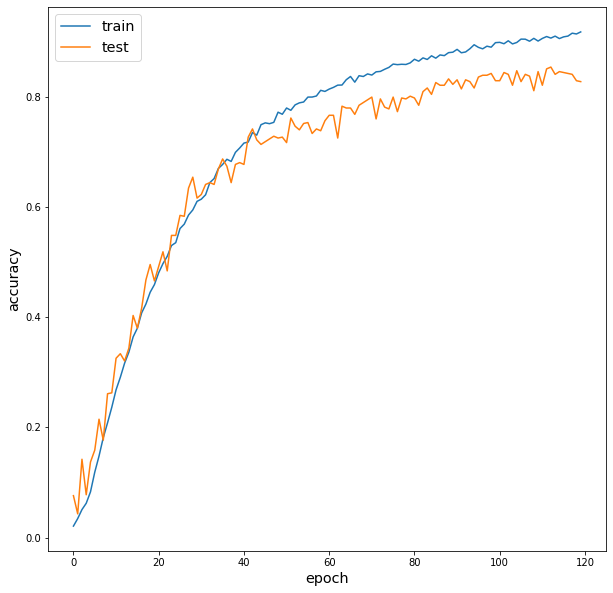

In [0]:
plt.figure(figsize=(10, 10))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('accuracy', fontsize='x-large')
plt.xlabel('epoch', fontsize='x-large')
plt.legend(['train', 'test'], loc='upper left', fontsize='x-large')

**Get predictions from the test set to visualize the results.**

In [0]:
y_pred = model.predict(X_test, batch_size=len(X_test), verbose=1)
y_pred = np.argmax(y_pred, axis=1)

605/605 [==============================] - 1s 1ms/step


 **We reached an overall accuracy of around  85%. Let's take a look at the Confusion Matrix** 

In [0]:
def plot_confusion_matrix(cm, classes, cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    tick_marks = np.arange(0, len(classes), 2)
    plt.xticks(tick_marks, classes[tick_marks], rotation=90)
    plt.yticks(tick_marks, classes[tick_marks])
    plt.ylabel('True label', fontsize='x-large')
    plt.xlabel('Predicted label', fontsize='x-large')

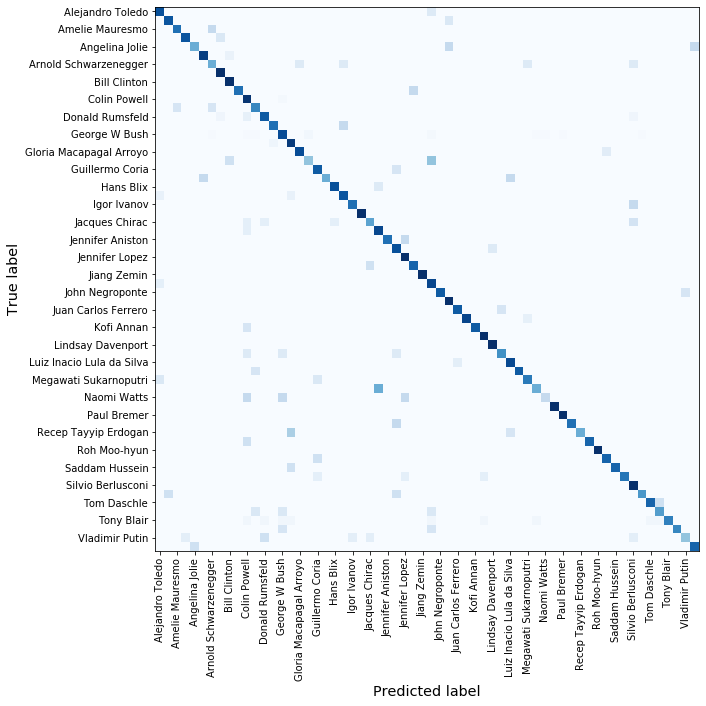

In [0]:
plt.figure(figsize=(10, 10))
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm, classes=target_names)
plt.grid(False)

**Assuming that all classes have the same importance, more appropriate measure would be the average accuracy among all classes.**

In [0]:
def plot_barh(labels, values):
    fig = plt.figure(figsize=(12, 8))
    y_pos = np.arange(len(labels))
    plt.barh(y_pos, values, align='center', alpha=0.5)
    plt.yticks(y_pos, labels)
    plt.xticks(np.arange(0.0, 1.0, 0.05))
    plt.xlabel('accuracy', fontsize='x-large')
    plt.axes().xaxis.grid(color='black', linestyle='-', linewidth=0.5)
    axes = plt.gca()
    axes.set_xlim([0.0, 1.0])
    axes.axvline(np.mean(values), color='green', linewidth=2)
    plt.tight_layout()

In [0]:
class_accuracies = [cm[i, i] for i in range(cm.shape[0])]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


average accuracy: 79.2%


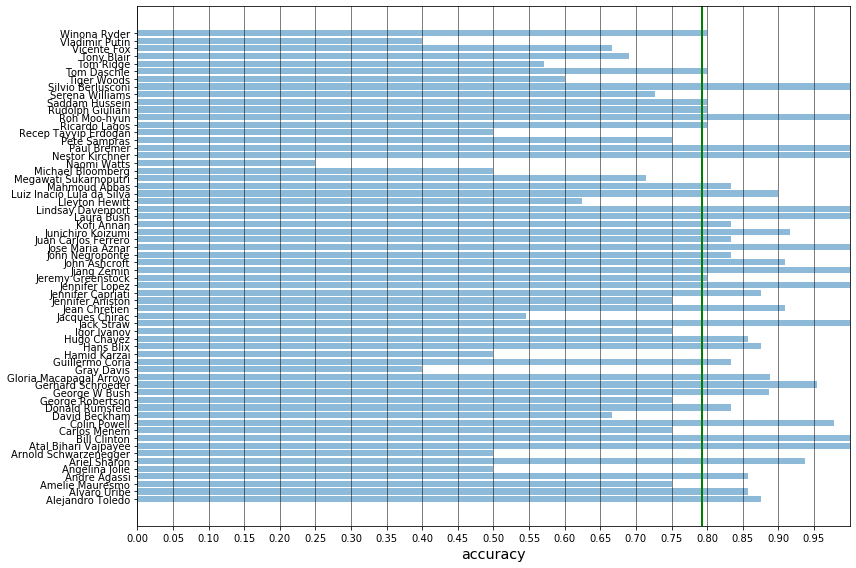

In [0]:
plot_barh(target_names, class_accuracies)
print('average accuracy: {}%'.format(np.round(np.mean(class_accuracies) * 100.0, 1)))